### Setup

If you want to write your own code and not follow this format, it is ok. Just make sure to use the same hyperparameters and models. If you see convergence sooner during the training, you may use fewer iterations.

In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

# Latent dimensions
z = 10
# Training iterations
iter_max = 200
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load dataset

In [2]:
def get_mnist_data(device, batch_size):
    preprocess = transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True, transform=preprocess),
        batch_size=batch_size,
        shuffle=True)

    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)

    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)
train_loader

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Utility Functions
- Complete the code for the function ```sample_gaussian```

In [3]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    ################################################################################
    # TODO: complete the code here
    # Task: Sample z
    #std = torch.exp(0.5 * v)
    eps = torch.randn_like(v)
    z = eps * torch.sqrt(v) + m
    # End 
    ################################################################################
    
    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

### Base Models

In [4]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

- Complete the function ```negative_elbo_bound```. Make sure to use functions provided in the ***Utility*** and ***Base Model*** sections for your benefit when completing the code.

In [5]:


class VAE(nn.Module):
    def __init__(self, name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim

        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: complete the code here
        # Task: Compute negative Evidence Lower Bound and its KL and Reconstruction term
        # Note that nelbo = kl + rec
        # Outputs should all be scalar
        qm, qv = self.enc.encode(x)
        pm, pv = self.z_prior
        kl = kl_normal(qm, qv, pm, pv).mean()
        z = sample_gaussian(qm, qv)
        #x_reconstructed = self.compute_sigmoid_given(z)
        x_reconstructed = self.dec.decode(z)
        rec = -1 * (log_bernoulli_with_logits(x, x_reconstructed).mean())
        nelbo = kl + rec
        # End 
        ################################################################################
        
        return nelbo, kl, rec

    
    def loss(self, x):
        nelbo, kl, rec = self.negative_elbo_bound(x)
        loss = nelbo

        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))

        return loss, summaries

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


### Run model

- You will probably need to add some lines to this code. (Add test set, save statistics and plot, ...)

Note that Negative ELBO on the test set should be around 100. 

In [6]:
log_dict = {'train_negative_elbo': [],
                'train_reconstruction_loss': [],
                'train_kl_loss': []}
log_dict_test = {'test_negative_elbo': [],
                'test_reconstruction_loss': [],
                'test_kl_loss': []}
vae = VAE(z_dim=z).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

for i in tqdm(range(iter_max)):
    for batch_idx, (xu, yu) in enumerate(train_loader):
            
        optimizer.zero_grad()
        #print("xu :",xu.reshape(xu.size(0), -1).shape)

        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        yu = yu.new(np.eye(10)[yu]).to(device).float()
        loss, summaries = vae.loss(xu)

        loss.backward()
        optimizer.step()
        
    #print(summaries['train/loss'])
    
    ################################################################################
    # TODO: complete the code here
    # report the loss terms across time for train and validation datasets
    #
    # You can choose to only perform validation once in every 10 (Or any other number 
    # depending on the speed of the algorithm on your machine) iterations and display  
    # the training and validation statistics on those iterataions.

    # LOGGING
    log_dict['train_negative_elbo'].append(summaries['train/loss'].item())
    log_dict['train_reconstruction_loss'].append(summaries['gen/rec'].item())
    log_dict['train_kl_loss'].append(summaries['gen/kl_z'].item())

    #print('train***Epoch:  , Loss: ,reconstruction_loss  ,kl_loss : ', (i+1, summaries['train/loss'].item(),summaries['gen/rec'].item(),summaries['gen/kl_z'].item()))

    #evalution

    with torch.no_grad():
      for batch_idx, (xu, yu) in enumerate(test_loader):
        xu = torch.bernoulli(xu.to(device).reshape(xu.size(0), -1))
        loss_test, summaries_test = vae.loss(xu)


    log_dict_test['test_negative_elbo'].append(summaries_test['train/loss'].item())
    log_dict_test['test_reconstruction_loss'].append(summaries_test['gen/rec'].item())
    log_dict_test['test_kl_loss'].append(summaries_test['gen/kl_z'].item())

    #print('\ntest***Epoch:  , Loss: ,reconstruction_loss  ,kl_loss : ', (i+1, summaries_test['train/loss'].item(),summaries_test['gen/rec'].item(),summaries_test['gen/kl_z'].item()))
    # End
    ################################################################################

100%|██████████| 200/200 [27:57<00:00,  8.39s/it]


In [21]:
import matplotlib.pyplot as plt

def plott(a,b,title,y_label): 
    #plt.figure(figsize=(25,8))
    plt.plot(range(0,200), a, color='r', label='train')
    plt.plot(range(0,200), b, color='b', label='test')
    plt.xlabel("iterations")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show();

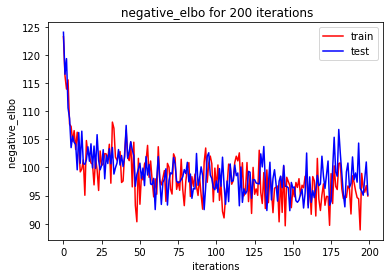

In [22]:
plott(log_dict['train_negative_elbo'],log_dict_test['test_negative_elbo']," negative_elbo for 200 iterations","negative_elbo ")

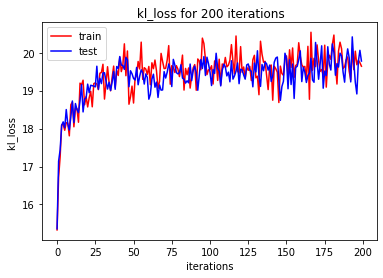

In [23]:
plott(log_dict['train_kl_loss'],log_dict_test['test_kl_loss']," kl_loss for 200 iterations","kl_loss ")

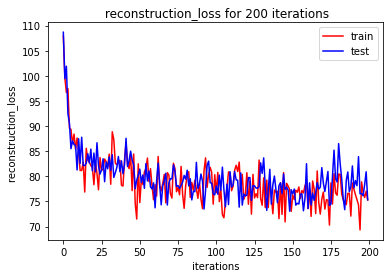

In [24]:
plott(log_dict['train_reconstruction_loss'],log_dict_test['test_reconstruction_loss']," reconstruction_loss for 200 iterations","reconstruction_loss ")

In [25]:
from mpl_toolkits.axes_grid1 import ImageGrid
def make_gridd(a,axes_size):
  b = list(a.cpu())
  fig = plt.figure(figsize=(10., 10.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(axes_size, axes_size),  # creates axes_size*axes_size grid of axes
                  axes_pad=0,  # pad between axes in inch.
                  )

  for ax, im in zip(grid, b):
      # Iterating over the grid returns the Axes.
      ax.imshow(im.reshape(28,28).detach().numpy())
      ax.axis("off")
  plt.show()

In [28]:
img_gen = vae.sample_x(100)

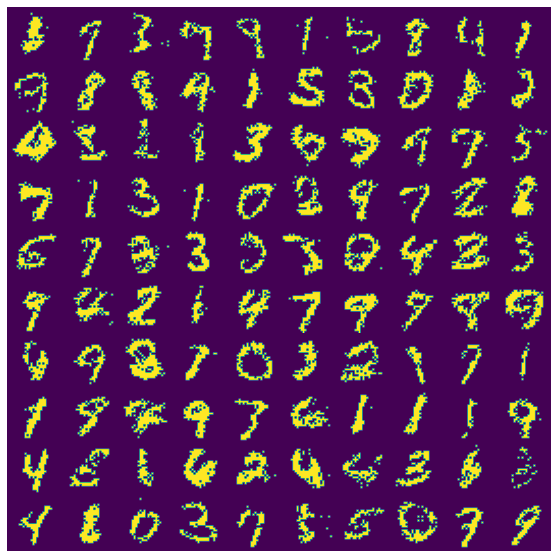

In [29]:
make_gridd(img_gen,10)

In [ ]:
vae.